# Spatial Tools Demo

Also available in self-contained Colab notebook

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1-dfCosj9XoesFt7byIhp84p2JMUuHxby?usp=sharing "NITorch Spatial Tools Demo")

##### For offline version:

In [1]:
# GETTING STARTED
# This demo was run on:
# * Ubuntu    18.04.4 LTS / CentOS 7.7.1908
# * CUDA      10.1
# * anaconda  1.7.2
# * gcc       6.3.1
# * pytorch   1.6
#
# To get started, run the following commands in a terminal:
#
#   git clone git@github.com:balbasty/nitorch.git
#   cd nitorch
#   conda env create --file ./conda/nitorch-demo.yml
#   conda activate nitorch-demo
#   pip install .

### Installations

First clone the repo...

In [2]:
!git clone https://github.com/balbasty/nitorch

Set-up of NITorch and dependencies

In [3]:
! pip install numpy
! pip install nibabel
! pip install matplotlib
! pip install scipy

In [4]:
! pip install ./nitorch/

Above cells can be pasted into your own colab notebook for easy install

## GETTING STARTED

First, I will import required packages:

In [5]:
# Python
import os
import wget
import math
from timeit import default_timer as timer

# Torch / NiBabel
import nibabel as nib
import torch
from torch.nn import functional as F

# NiTorch
from nitorch.core.kernels import smooth
from nitorch.spatial import (affine_matrix_classic, affine_grid, identity_grid,
                             grid_pull, grid_push, voxel_size)
from nitorch.plot import show_slices
from nitorch.core.utils import pad
from nitorch.core.linalg import lmdiv

and get the PyTorch device:

In [6]:
device_type = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_type)
if device_type == 'cuda':
    print('GPU: ' + torch.cuda.get_device_name(0) + ', CUDA: ' + str(torch.cuda.is_available()))
else:
    print('CPU')

GPU: NVIDIA RTX A6000, CUDA: True


I will in this demo use an (almost) 1 mm isotropic T1w MRI from the IXI dataset (http://brain-development.org/ixi-dataset/):

In [7]:
# URL to MRI
url = 'https://www.dropbox.com/s/vsq2yczm1c343wv/IXI002-T1-Guys-0828-MPRAGESEN_-s256_-0301-00003-000001-01.nii?dl=1'

# Path to downloaded image file
pth = 'IXI002-T1-Guys-0828-MPRAGESEN_-s256_-0301-00003-000001-01.nii'

# Download file
if not os.path.exists(pth):
    print('Downloading image...', end='')
    wget.download(url, pth)
    print('done!')

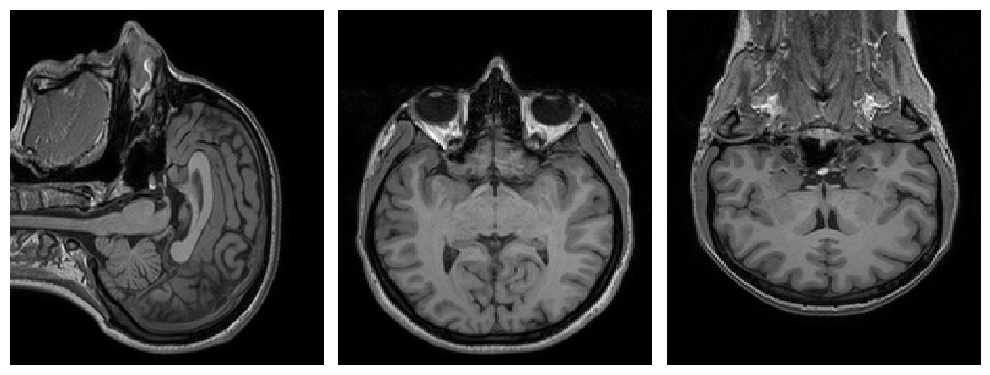

In [8]:
# Get image data and affine matrix
nii = nib.load(pth)
mat_in = torch.tensor(nii.affine).double().to(device)
dat_in = torch.tensor(nii.get_fdata()).float().to(device)
dat_in_cpu = dat_in.cpu()
dim_in = dat_in.shape
vx_in = voxel_size(mat_in)

# Look at input
fig = show_slices(dat_in, figsize=(10, 4))

Finally, I will set some `nitorch` specifics (for detailed documentation look at header of individual nitorch functions):

In [9]:
bound = 'zero'  # what boundary condition to assume
extrapolate = True  # what to do with voxels that falls outside of the field of view
interpolation = 1  # degree of interpolation

# Make dimensionality compatible with nitorch (input should have dimensions (batch, channels, X, Y, Z))
dat_in = dat_in[None, None, ...]
dat_in_cpu = dat_in_cpu[None, None, ...]

## Example 1: Randomly realign image

This example will apply a random realignment (translation + rotation) to the input image using `nitorch`, comparing doing so on the GPU and the CPU. Note that this example could easily be modified to apply just a flip or a shift.

In [10]:
# Create an affine matrix that does a random shift in translation and a rotation
p = torch.zeros(6, device=dat_in.device, dtype=torch.float64)
p[:3] = 5*torch.randn(3, device=dat_in.device, dtype=torch.float64)  # translation
p[3:] = 5*torch.randn(3, device=dat_in.device, dtype=torch.float64)*(math.pi/180)  # rotation
mat_out = affine_matrix_classic(p)

# Create an identity grid of size dim_in and apply affine matrix mat_out
grid = affine_grid(mat_out, dim_in).type(dat_in.dtype)[None, ...]
grid_cpu = grid.cpu()

Run on the **GPU**:

device=cuda:0 | elapsed time: 0.0048 seconds


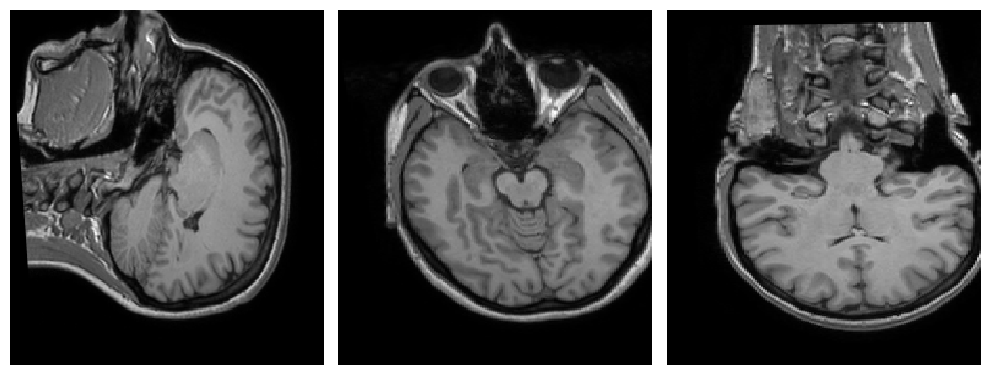

In [11]:
# Pull (resample) input image (dat_in) on the GPU
t = timer()  # Start timer
dat_pull = grid_pull(dat_in, grid,
                     bound=bound, extrapolate=extrapolate, interpolation=interpolation)
print('device={} | elapsed time: {:0.4f} seconds'.format(dat_pull.device, timer() - t))

fig = show_slices(dat_pull[0, 0, ...], figsize=(10, 4))


Run on the **CPU**:

device=cpu | elapsed time: 0.0750 seconds


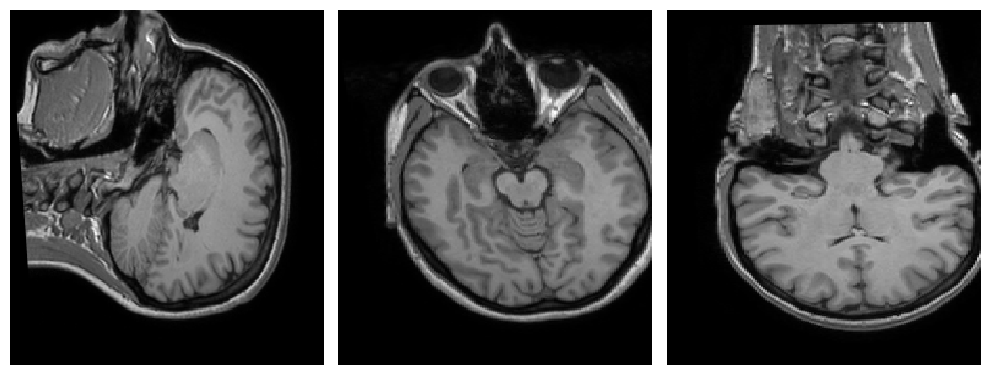

In [12]:
# Pull (resample) input image (dat_in) on the CPU
t = timer()  # Start timer
dat_pull = grid_pull(dat_in_cpu, grid_cpu,
                     bound=bound, extrapolate=extrapolate, interpolation=interpolation)
print('device={} | elapsed time: {:0.4f} seconds'.format(dat_pull.device, timer() - t))

fig = show_slices(dat_pull[0, 0, ...], figsize=(10, 4))

## Example 2: Pull isotropic to anisotropic, then push (splat)

This example will make the input (near to 1 mm isotropic) image thick-sliced. It will then use the adjoint of the pull operation to push (splat) the generated thick-sliced image back to its isotropic space.

In [13]:
# Set output voxel size
vx_out = torch.tensor([1.0, 1.0, 6.0], device=dat_in.device, dtype=torch.float64)

# Get output dimensions and orientation matrix
one = torch.tensor(1.0, device=dat_in.device, dtype=torch.float64)[..., None]
D = torch.diag(torch.cat((vx_out / vx_in, one)))
mat_out = mat_in.mm(D)
mat_out[:3, 3] = mat_out[:3, 3] + 0.5*(vx_out - vx_in)
dim_out = D.inverse()[:3, :3].mm(torch.tensor(dim_in, device=dat_in.device,
                                 dtype=torch.float64).reshape((3, 1))).ceil().squeeze()
dim_out = dim_out.int().cpu().tolist()

# Create an identity grid of size dim_out and apply affine matrix mat_pull
mat_pull = lmdiv(mat_in, mat_out)
grid = affine_grid(mat_pull, dim_out).type(dat_in.dtype)[None, ...]
grid_cpu = grid.cpu()


Run on the **GPU**:

device=cuda:0 | elapsed time: 0.0033 seconds


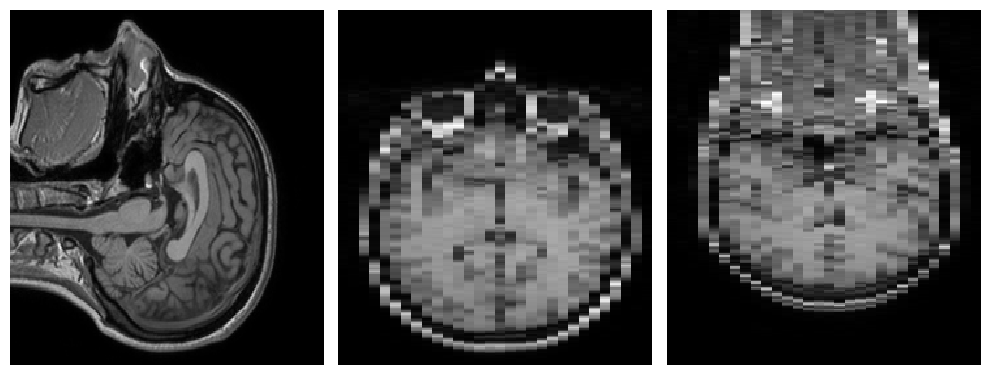

In [14]:
# Pull (resample) input image (dat_in) on the GPU
t = timer()  # Start timer
dat_pull = grid_pull(dat_in, grid,
                     bound=bound, extrapolate=extrapolate, interpolation=interpolation)
print('device={} | elapsed time: {:0.4f} seconds'.format(dat_pull.device, timer() - t))

fig = show_slices(dat_pull[0, 0, ...], figsize=(10, 4))

device=cuda:0 | elapsed time: 0.0051 seconds


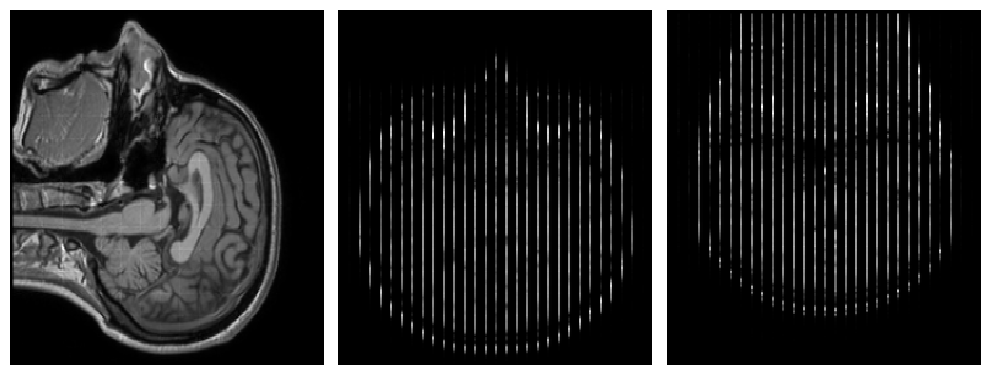

In [15]:
# Push the pulled image, on the GPU
t = timer()  # Start timer
dat_push = grid_push(dat_pull, grid, shape=dim_in,
                     bound=bound, extrapolate=extrapolate, interpolation=interpolation)
print('device={} | elapsed time: {:0.4f} seconds'.format(dat_push.device, timer() - t))

fig = show_slices(dat_push[0, 0, ...], figsize=(10, 4))


Run on the **CPU**:

device=cpu | elapsed time: 0.0159 seconds


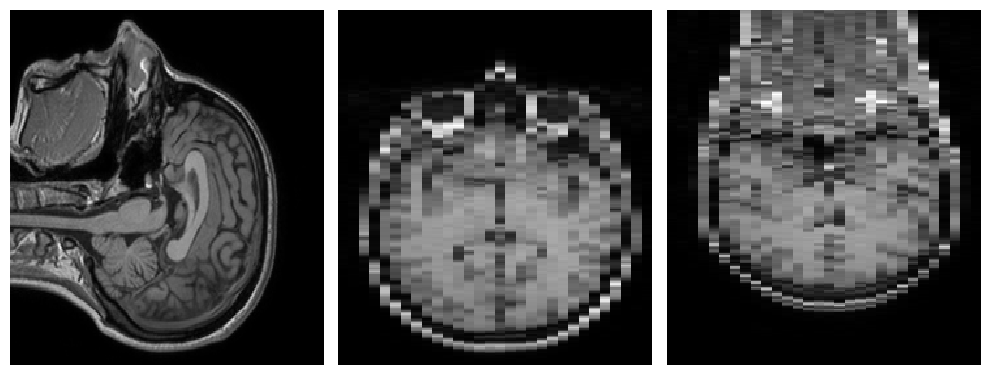

In [16]:
# Pull (resample) input image (dat_in) on the CPU
t = timer()  # Start timer
dat_pull = grid_pull(dat_in_cpu, grid_cpu,
                     bound=bound, extrapolate=extrapolate, interpolation=interpolation)
print('device={} | elapsed time: {:0.4f} seconds'.format(dat_pull.device, timer() - t))

fig = show_slices(dat_pull[0, 0, ...], figsize=(10, 4))

device=cpu | elapsed time: 0.0097 seconds


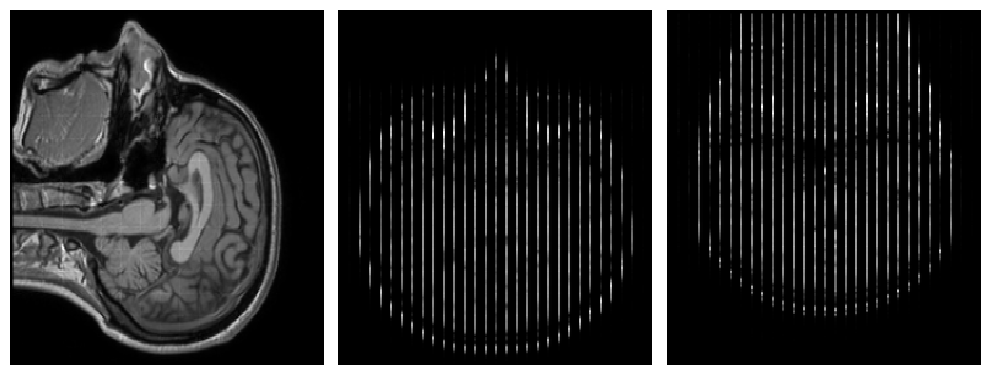

In [17]:
# Push the pulled image, on the GPU
t = timer()  # Start timer
dat_push = grid_push(dat_pull, grid_cpu, shape=dim_in,
                     bound=bound, extrapolate=extrapolate, interpolation=interpolation)
print('device={} | elapsed time: {:0.4f} seconds'.format(dat_push.device, timer() - t))

fig = show_slices(dat_push[0, 0, ...], figsize=(10, 4))


## Example 3: Apply random deformation

This example will apply a random (nonlinear) deformation to the input image. The nonlinear deformation is generated by simply sampling from a Gaussian and then smoothing this sampled data.

In [18]:
# Parameters of random displacement
kernel = 'gauss'
sd = 10
fwhm = 5

# Create an identity grid of size dim_in
grid = identity_grid(dim_in, device=dat_in.device, dtype=dat_in.dtype)

# Simulate a random displacement
df = sd*torch.randn(grid.shape, device=dat_in.device, dtype=dat_in.dtype)

# Make smoothing kernel
smo = smooth((kernel,) * 3, fwhm=(fwhm,) * 3, device=dat_in.device, dtype=dat_in.dtype, sep=False)

# Padding amount for subsequent convolution
p = (torch.tensor(smo.shape[2:]) - 1)//2
p = tuple(p.int().cpu().tolist())

# Smooth displacement with Gaussian kernel (by convolving)
for d in range(3):
    tmp = pad(df[..., d], p, side='both')
    tmp = F.conv3d(tmp[None, None, ...], smo)[0, 0, ...]
    df[..., d] = tmp

# Apply the displacement to the identity grid to make the random deformation
grid = grid + df

grid = grid[None, ...]
grid_cpu = grid.cpu()

Run on the **GPU**:

device=cuda:0 | elapsed time: 0.0043 seconds


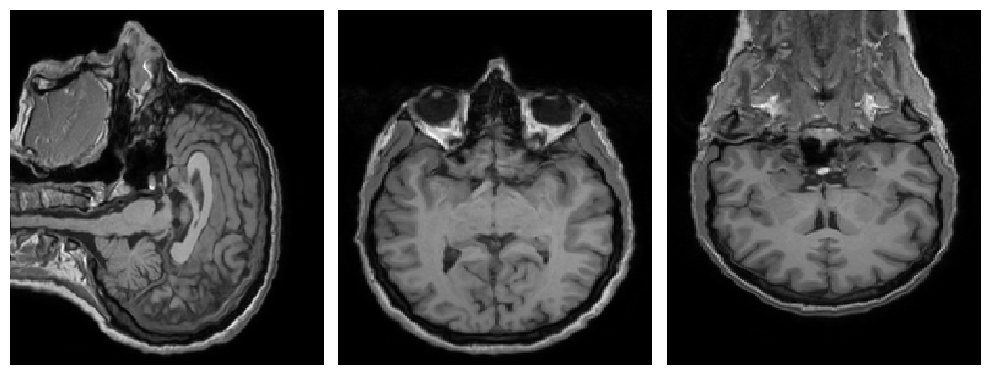

In [19]:
# Pull (resample) input image (dat_in) on the GPU
t = timer()  # Start timer
dat_pull = grid_pull(dat_in, grid,
                     bound=bound, extrapolate=extrapolate, interpolation=interpolation)
print('device={} | elapsed time: {:0.4f} seconds'.format(dat_pull.device, timer() - t))

fig = show_slices(dat_pull[0, 0, ...], figsize=(10, 4))

Run on the **CPU**:

device=cpu | elapsed time: 0.0786 seconds


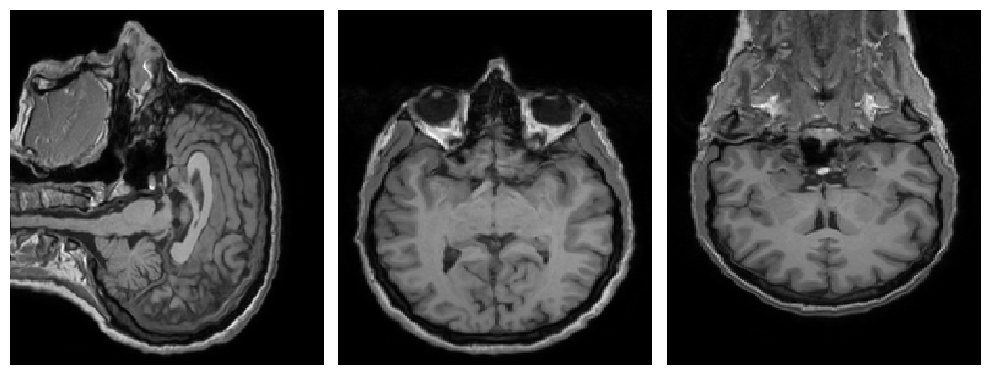

In [20]:
# Pull (resample) input image (dat_in) on the CPU
t = timer()  # Start timer
dat_pull = grid_pull(dat_in_cpu, grid_cpu,
                     bound=bound, extrapolate=extrapolate, interpolation=interpolation)
print('device={} | elapsed time: {:0.4f} seconds'.format(dat_pull.device, timer() - t))

fig = show_slices(dat_pull[0, 0, ...], figsize=(10, 4))